In [52]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

ratings = pd.read_csv('/home/manishn/recommend/data/ml-latest-small/ratings.csv')
movies = pd.read_csv('/home/manishn/recommend/data/ml-latest-small/movies.csv')

In [7]:
ratings.head()

,userId,movieId,rating,timestamp
0,1,1,4.0,964982703
1,1,3,4.0,964981247
2,1,6,4.0,964982224
3,1,47,5.0,964983815
4,1,50,5.0,964982931


In [8]:
movies.head()

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


In [9]:
movies['genres'] = movies['genres'].apply(lambda x: x.split('|'))


In [10]:
merged = pd.merge(ratings, movies, on='movieId')
merged= merged[['userId', 'movieId', 'title', 'genres', 'rating', 'timestamp']]
merged.to_csv('merged_ratings.csv', index=False)
merged

,userId,movieId,title,genres,rating,timestamp
0,1,1,Toy Story (1995),"[Adventure, Animation, Children, Comedy, Fantasy]",4.0,964982703
1,5,1,Toy Story (1995),"[Adventure, Animation, Children, Comedy, Fantasy]",4.0,847434962
2,7,1,Toy Story (1995),"[Adventure, Animation, Children, Comedy, Fantasy]",4.5,1106635946
3,15,1,Toy Story (1995),"[Adventure, Animation, Children, Comedy, Fantasy]",2.5,1510577970
4,17,1,Toy Story (1995),"[Adventure, Animation, Children, Comedy, Fantasy]",4.5,1305696483
...,...,...,...,...,...,...
100831,610,160341,Bloodmoon (1997),"[Action, Thriller]",2.5,1479545749
100832,610,160527,Sympathy for the Underdog (1971),"[Action, Crime, Drama]",4.5,1479544998
100833,610,160836,Hazard (2005),"[Action, Drama, Thriller]",3.0,1493844794
100834,610,163937,Blair Witch (2016),"[Horror, Thriller]",3.5,1493848789


/tmp/ipykernel_1521158/943713701.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x="rating", data=ratings, palette="viridis")


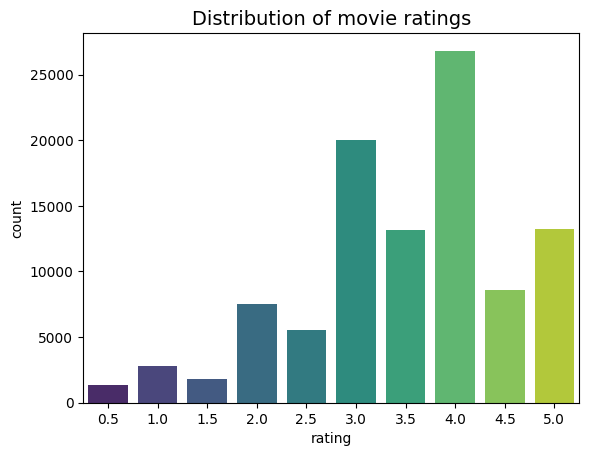

In [14]:
import seaborn as sns
sns.countplot(x="rating", data=ratings, palette="viridis")
plt.title("Distribution of movie ratings", fontsize=14)
plt.show()


In [59]:
avg_rating_per_movie = merged.groupby('movieId')['rating'].mean()
print(avg_rating_per_movie.head())


movieId
1    3.920930
2    3.431818
3    3.259615
4    2.357143
5    3.071429
Name: rating, dtype: float64


In [60]:
rating_counts_per_movie = merged.groupby('movieId')['rating'].count()
print(rating_counts_per_movie.head())


movieId
1    215
2    110
3     52
4      7
5     49
Name: rating, dtype: int64


In [61]:
rating_counts_per_user = merged.groupby('userId')['rating'].count()
print(rating_counts_per_user.head())


userId
1    232
2     29
3     39
4    216
5     44
Name: rating, dtype: int64


In [65]:
active_users = rating_counts_per_user[rating_counts_per_user >= 5].index
popular_movies = rating_counts_per_movie[rating_counts_per_movie >= 5].index
df = merged[merged['userId'].isin(active_users) & merged['movieId'].isin(popular_movies)]
df

,userId,movieId,title,genres,rating,timestamp
0,1,1,Toy Story (1995),"[Adventure, Animation, Children, Comedy, Fantasy]",4.0,964982703
1,5,1,Toy Story (1995),"[Adventure, Animation, Children, Comedy, Fantasy]",4.0,847434962
2,7,1,Toy Story (1995),"[Adventure, Animation, Children, Comedy, Fantasy]",4.5,1106635946
3,15,1,Toy Story (1995),"[Adventure, Animation, Children, Comedy, Fantasy]",2.5,1510577970
4,17,1,Toy Story (1995),"[Adventure, Animation, Children, Comedy, Fantasy]",4.5,1305696483
...,...,...,...,...,...,...
99023,465,3723,Hamlet (1990),[Drama],5.0,959895645
99024,474,3723,Hamlet (1990),[Drama],4.0,979180620
99025,480,3723,Hamlet (1990),[Drama],3.5,1179162084
99026,599,3723,Hamlet (1990),[Drama],3.0,1519234508


In [66]:
MovieUserMatrix = df.pivot_table(index='movieId',columns='userId',values='rating')
MovieUserMatrix_Y=MovieUserMatrix.fillna(0)
MovieUserMatrix_R=MovieUserMatrix.copy()
MovieUserMatrix_R=MovieUserMatrix_R.where(~MovieUserMatrix_R.notna(), 1)
MovieUserMatrix_R=MovieUserMatrix_R.fillna(0)
Y=MovieUserMatrix_Y.values #converting to numpy array
R=MovieUserMatrix_R.values

In [68]:
Y.shape

(3650, 610)

#**Model**

In [77]:
import torch
import numpy as np
from sklearn.model_selection import train_test_split

# Y: (num_movies, num_users) - Ratings matrix with zeros for missing values
# R: (num_movies, num_users) - Binary matrix where R[i, j] = 1 if Y[i, j] is a real rating, 0 otherwise
num_movies, num_users = Y.shape

# Extract indices of non-zero entries (observed ratings)
movie_ids, user_ids = np.where(R == 1)  # movie_ids and user_ids are arrays of indices
ratings = Y[movie_ids, user_ids]        # Corresponding ratings for these user-movie pairs

#Create a list of tuples (user_id, movie_id, rating)
data = list(zip(user_ids, movie_ids, ratings))

# Step 3: Split the data into training, validation, and test sets
train_data, test_data = train_test_split(data, test_size=0.2, random_state=42)
train_data, val_data = train_test_split(train_data, test_size=0.1, random_state=42)  # 10% of training data for validation

# Step 4: Convert the data to PyTorch tensors for training
def prepare_data(data):
    user_ids = torch.tensor([x[0] for x in data], dtype=torch.long)
    movie_ids = torch.tensor([x[1] for x in data], dtype=torch.long)
    ratings = torch.tensor([x[2] for x in data], dtype=torch.float32)
    return user_ids, movie_ids, ratings

# Prepare training, validation, and test tensors
train_user_ids, train_movie_ids, train_ratings = prepare_data(train_data)
val_user_ids, val_movie_ids, val_ratings = prepare_data(val_data)
test_user_ids, test_movie_ids, test_ratings = prepare_data(test_data)

print(f"Training set size: {len(train_user_ids)}")
print(f"Validation set size: {len(val_user_ids)}")
print(f"Test set size: {len(test_user_ids)}")



Training set size: 64997
Validation set size: 7222
Test set size: 18055


In [73]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
from sklearn.model_selection import train_test_split
from math import sqrt

# Define the NeuMF model for regression
class NeuMF(nn.Module):
    def __init__(self, num_users, num_movies, mf_dim=10, mlp_hidden_dims=[20, 10], dropout=0.2):
        super(NeuMF, self).__init__()
        
        # GMF part
        self.user_embedding_gmf = nn.Embedding(num_users, mf_dim)
        self.movie_embedding_gmf = nn.Embedding(num_movies, mf_dim)
        
        # MLP part
        self.user_embedding_mlp = nn.Embedding(num_users, mlp_hidden_dims[0])
        self.movie_embedding_mlp = nn.Embedding(num_movies, mlp_hidden_dims[0])
        
        # Define MLP layers
        mlp_layers = []
        input_dim = mlp_hidden_dims[0] * 2
        for hidden_dim in mlp_hidden_dims[1:]:
            mlp_layers.append(nn.Linear(input_dim, hidden_dim))
            mlp_layers.append(nn.ReLU())
            mlp_layers.append(nn.Dropout(p=dropout))
            input_dim = hidden_dim
        self.mlp = nn.Sequential(*mlp_layers)
        
        # Final layer combining GMF and MLP parts
        self.final_layer = nn.Linear(mf_dim + mlp_hidden_dims[-1], 1)
        
    def forward(self, user_indices, movie_indices):
        # GMF part
        user_embedding_gmf = self.user_embedding_gmf(user_indices)
        movie_embedding_gmf = self.movie_embedding_gmf(movie_indices)
        gmf_output = user_embedding_gmf * movie_embedding_gmf  # element-wise product
        
        # MLP part
        user_embedding_mlp = self.user_embedding_mlp(user_indices)
        movie_embedding_mlp = self.movie_embedding_mlp(movie_indices)
        mlp_input = torch.cat([user_embedding_mlp, movie_embedding_mlp], dim=-1)
        mlp_output = self.mlp(mlp_input)
        
        # Concatenate GMF and MLP outputs
        combined = torch.cat([gmf_output, mlp_output], dim=-1)
        
        # Predict interaction (e.g., rating)
        output = self.final_layer(combined)
        return output.squeeze()



In [74]:

# Instantiate the model, loss function, and optimizer
model = NeuMF(num_users=num_users, num_movies=num_movies, mf_dim=100, mlp_hidden_dims=[100, 80], dropout=0.2)
loss_function = nn.MSELoss()  # Mean Squared Error for regression
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training loop
num_epochs = 10
batch_size = 256

for epoch in range(num_epochs):
    model.train()
    epoch_loss = 0
    permutation = torch.randperm(len(train_user_ids))
    
    for i in range(0, len(train_user_ids), batch_size):
        batch_indices = permutation[i:i + batch_size]
        user_batch = train_user_ids[batch_indices]
        movie_batch = train_movie_ids[batch_indices]
        rating_batch = train_ratings[batch_indices]
        
        # Forward pass
        predictions = model(user_batch, movie_batch)
        loss = loss_function(predictions, rating_batch)
        
        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        epoch_loss += loss.item() * len(user_batch)
    
    # Calculate average training loss
    avg_train_loss = epoch_loss / len(train_user_ids)
    
    # Evaluate on validation set
    model.eval()
    with torch.no_grad():
        val_predictions = model(val_user_ids, val_movie_ids)
        val_loss = loss_function(val_predictions, val_ratings).item()
    
    print(f"Epoch {epoch + 1}/{num_epochs}, Training Loss: {avg_train_loss}, Validation Loss: {val_loss}")



Epoch 1/10, Training Loss: 2.914386968849303, Validation Loss: 0.9454677104949951
Epoch 2/10, Training Loss: 1.036390770609064, Validation Loss: 0.8620741367340088
Epoch 3/10, Training Loss: 0.9438686094656448, Validation Loss: 0.8282853960990906
Epoch 4/10, Training Loss: 0.8817758658193564, Validation Loss: 0.8041543960571289
Epoch 5/10, Training Loss: 0.841477738632001, Validation Loss: 0.792799711227417
Epoch 6/10, Training Loss: 0.8059797833687999, Validation Loss: 0.789040207862854
Epoch 7/10, Training Loss: 0.7764896851571789, Validation Loss: 0.7830448746681213
Epoch 8/10, Training Loss: 0.7547257922153384, Validation Loss: 0.7820870280265808
Epoch 9/10, Training Loss: 0.7264243220643601, Validation Loss: 0.7816079258918762
Epoch 10/10, Training Loss: 0.7041153258798064, Validation Loss: 0.7836220860481262


In [76]:

# Evaluate on test set
model.eval()
with torch.no_grad():
    test_predictions = model(test_user_ids, test_movie_ids)
    test_loss = loss_function(test_predictions, test_ratings).item()

    # Calculate RMSE
    rmse = sqrt(test_loss)
    print(f"Test Loss (MSE): {test_loss}")
    print(f"Test RMSE: {rmse}")


Test Loss (MSE): 0.805956244468689
Test RMSE: 0.8977506582947679


In [78]:
user_id = torch.tensor([5])  # Replace with the actual user ID (zero-indexed)
movie_id = torch.tensor([10])  # Replace with the actual movie ID (zero-indexed)

model.eval()
with torch.no_grad():
    prediction = model(user_id, movie_id)
    print(f"Predicted rating for user {user_id.item()} and movie {movie_id.item()}: {prediction.item()}")



Predicted rating for user 5 and movie 10: 4.064691066741943
